In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
import json
import sys
sys.path.append('../Utils')

datapath='../Dataset/'
df_train=pd.read_csv(datapath+'train_data_for_modeling(no_standardization).csv')
print(f'Successfully loaded train data, the shape is {df_train.shape}')

with open(datapath+'all_final_features.json', 'r') as f:
    all_final_features=json.load(f)

feature_cols=[col for col in all_final_features if col not in ['RESALE_PRICE', 'LOG_RESALE_PRICE']]

X=df_train[feature_cols]
y=df_train['RESALE_PRICE']

X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.2,random_state=42)
print('Successfully split the data')
print(f'The shape of train data is {X_train.shape},the shape of valid data is {X_valid.shape}')


Successfully loaded train data, the shape is (162570, 89)
Successfully split the data
The shape of train data is (130056, 87),the shape of valid data is (32514, 87)


In [12]:
# make the sale price log transformed
import numpy as np
y_train_log = y_train.apply(lambda x: np.log1p(x))
y_valid_log = y_valid.apply(lambda x: np.log1p(x))
y_log = y.apply(lambda x: np.log1p(x))

In [ ]:
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.4), 
        "n_estimators": trial.suggest_int('n_estimators', 100, 5000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 200),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10)
    }
    model = xgb.XGBRegressor(**param, 
                            random_state=42,
                            n_jobs=-1,
                            tree_method = "hist",
                            device="cuda",
                            eval_metric="rmse",
                            early_stopping_rounds=100,
                            )
    
    
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    fold_rmses = []

    for train_idx, valid_idx in kf.split(X):
        X_tr, X_va = X.iloc[train_idx], X.iloc[valid_idx]
        y_tr, y_va = y_log.iloc[train_idx], y_log.iloc[valid_idx]

        model = xgb.XGBRegressor(**param)

        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            verbose=False,
        )

        pred_va = model.predict(X_va)
        rmse = root_mean_squared_error(y_va, pred_va)
        fold_rmses.append(rmse)

    return np.mean(fold_rmses)
    # model.fit(
    #         X_train,
    #         y_train_log,
    #         eval_set=[(X_valid, y_valid_log)],
    #         verbose=False,
    #     )
    
    # y_pred = model.predict(X_valid)
    # score = root_mean_squared_error(y_valid_log, y_pred)
    # return score


In [14]:
!pip install optuna
import optuna 

study = optuna.create_study(
    direction="minimize",
    study_name="hdb_resale_price_study"
)
study.optimize(objective, n_trials=500, show_progress_bar=True)

best_params = study.best_params
print(f"\nBest parameters: {best_params}")

[I 2025-11-06 01:25:04,676] A new study created in memory with name: hdb_resale_price_study


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2025-11-06 01:25:43,399] Trial 0 finished with value: 0.06902101280813677 and parameters: {'max_depth': 5, 'learning_rate': 0.324482876793831, 'n_estimators': 983, 'subsample': 0.6991254704991106, 'colsample_bytree': 0.6430039840602351, 'min_child_weight': 10.352300432566638, 'gamma': 0.42603795685604906, 'reg_lambda': 6.360711950144941}. Best is trial 0 with value: 0.06902101280813677.
[I 2025-11-06 01:26:19,983] Trial 1 finished with value: 0.06804201475641462 and parameters: {'max_depth': 10, 'learning_rate': 0.13681231506794572, 'n_estimators': 815, 'subsample': 0.7391362386665103, 'colsample_bytree': 0.8476219547827049, 'min_child_weight': 166.23748414802992, 'gamma': 0.6537942260303242, 'reg_lambda': 1.596223013251945}. Best is trial 1 with value: 0.06804201475641462.
[I 2025-11-06 01:27:19,514] Trial 2 finished with value: 0.08399861568148718 and parameters: {'max_depth': 6, 'learning_rate': 0.11032825851484675, 'n_estimators': 1244, 'subsample': 0.5455523038482373, 'colsampl

KeyboardInterrupt: 

In [16]:
sys.path.append('../Utils')
from ML_training_utils_tools import evaluate_model
best_params = study.best_params

best_model = xgb.XGBRegressor(**best_params, 
                            random_state=42,
                            n_jobs=-1,
                            tree_method = "hist",
                            device="cuda",
                            eval_metric="rmse",
                            )
best_model.fit(X_train, y_train_log, eval_set=[(X_valid, y_valid_log)], verbose=False)

y_pred_train_log = best_model.predict(X_train)
y_pred_valid_log = best_model.predict(X_valid)
y_pred_train = np.expm1(y_pred_train_log)
y_pred_valid = np.expm1(y_pred_valid_log)

train_rmse,train_mae,train_r2=evaluate_model(y_train,y_pred_train,'Train')
valid_rmse,valid_mae,valid_r2=evaluate_model(y_valid,y_pred_valid,'Valid')
print(f"Train RMSE: {train_rmse}, MAE: {train_mae}, R2: {train_r2}")
print(f"Valid RMSE: {valid_rmse}, MAE: {valid_mae}, R2: {valid_r2}")

/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:17:00] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [10:17:00] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)



Train Performance:
  RMSE: $19,672.75
  MAE:  $14,386.03
  R²:   0.9885

Valid Performance:
  RMSE: $25,792.47
  MAE:  $18,336.04
  R²:   0.9800
Train RMSE: 19672.753882720615, MAE: 14386.0297244264, R2: 0.9885010613526983
Valid RMSE: 25792.470270456604, MAE: 18336.039092102634, R2: 0.9800320494190373


In [17]:
from sklearn.metrics import root_mean_squared_error 

print(f"Valid RMSE: {root_mean_squared_error(y_valid, y_pred_valid)}")

Valid RMSE: 25792.470270456604


/tmp/ipykernel_69526/3570082594.py:3: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  vis.matplotlib.plot_param_importances(study)
/tmp/ipykernel_69526/3570082594.py:4: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  vis.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

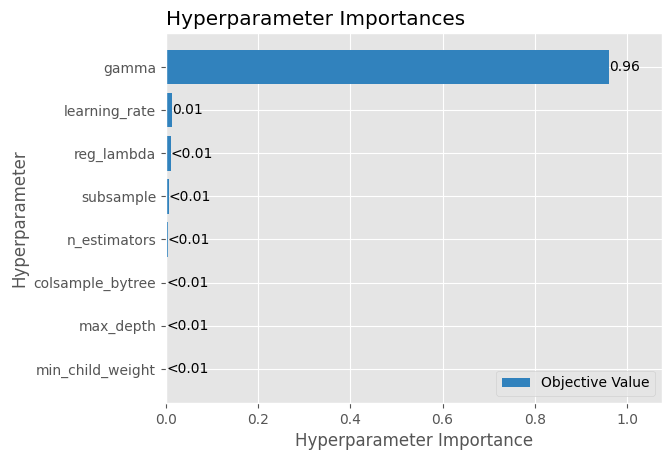

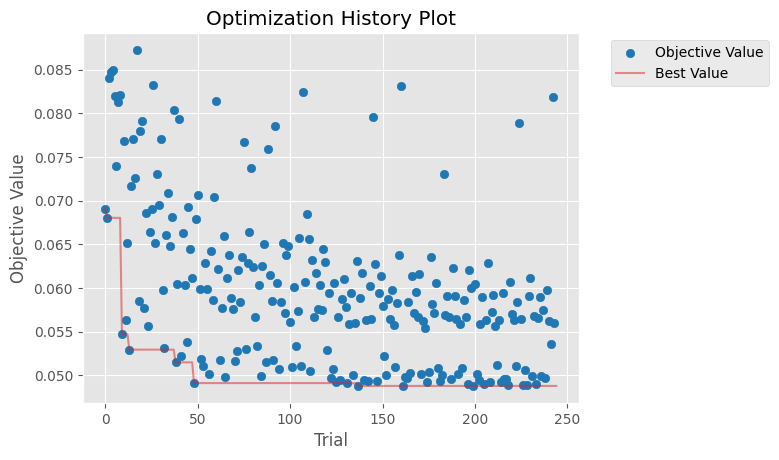

In [18]:
import optuna.visualization as vis

vis.matplotlib.plot_param_importances(study)
vis.matplotlib.plot_optimization_history(study)


In [19]:
import pandas as pd, json, pathlib as pl
out = pl.Path('./results/')
out.mkdir(parents=True, exist_ok=True)

df_test = pd.read_csv(datapath+'test_data_for_modeling(no_standardization).csv')
X_test = df_test[feature_cols]
y_test_log = best_model.predict(X_test)
y_test = np.expm1(y_test_log)

# save y_test predictions
pd.DataFrame({'Predicted': y_test}).to_csv(out/'xgb_test_predictions.csv', index=True)
(out/'xgb_best_params.json').write_text(json.dumps(best_params, indent=2))

271